In [ ]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Retrievals.ipynb --to python"
# call(command,shell=True)

In [1]:
import os
import cv2
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

device: cuda


/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = "--data_path=../data \
                    --subj=1 \
                    --model_name=zebra\
                    --model_name2=temp_2/poison_0_1"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)

['--data_path=../data', '--subj=1', '--model_name=zebra', '--model_name2=temp_2/poison_0_1']


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str,
    help="name of 257x768 model, used for everything except LAION-5B retrieval",
)
parser.add_argument(
    "--model_name2", type=str,
    help="name of 1x768 model, used for LAION-5B retrieval",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-medarc/fmri/natural-scenes-dataset",
    help="Path to where NSD data is stored (see README)",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [4]:
subj = 1 #note: we only trained subjects 1 2 5 7, since they have data across full sessions
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


# LAION-5B Retrieval

In [ ]:
val_url = f"{data_path}/test_subj0{subj}_" + "{0..1}.tar"
meta_url = f"{data_path}/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = val_batch_size = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

In [ ]:
out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim, h=256)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    ).to(device)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
).to(device)

outdir = f'../train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

In [ ]:
# CLS model
out_dim = 768
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip_cls = BrainNetwork(**voxel2clip_kwargs)
voxel2clip_cls.requires_grad_(False)
voxel2clip_cls.eval()

diffusion_prior_cls = BrainDiffusionPriorOld.from_pretrained(
    # kwargs for DiffusionPriorNetwork
    dict(),
    # kwargs for DiffusionNetwork
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip_cls,
    ),
    voxel2clip_path=None,
)

outdir = f'../train_logs/{model_name2}'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior_cls.load_state_dict(state_dict,strict=False)
diffusion_prior_cls.eval().to(device)
pass

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

retrieve = True
plotting = False
saving = True
verbose = False
imsize = 512

all_brain_recons = None
ind_include = np.arange(num_val)

for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=len(ind_include))):
    if val_i<np.min(ind_include):
        continue
    voxel = torch.mean(voxel,axis=1).to(device)
    # voxel = voxel[:,0].to(device)
    with torch.no_grad():        
        grid, brain_recons, laion_best_picks, recon_img = utils.reconstruction(
            img, voxel,
            clip_extractor,
            #voxel2clip_cls = diffusion_prior_cls.voxel2clip,
            diffusion_priors = diffusion_priors,
            text_token = None,
            n_samples_save = batch_size,
            recons_per_sample = 0,
            seed = seed,
            retrieve = retrieve,
            plotting = plotting,
            verbose = verbose,
            num_retrieved=16,
        )
            
        if plotting:
            plt.show()
            # grid.savefig(f'evals/{model_name}_{val_i}.png')
            # plt.close()
            
        brain_recons = brain_recons[laion_best_picks.astype(np.int8)]

        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_images = torch.vstack((all_images,img))
            
    if val_i>=np.max(ind_include):
        break

all_brain_recons = all_brain_recons.view(-1,3,imsize,imsize)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

if saving:
    torch.save(all_images,'all_images.pt')
    torch.save(all_brain_recons,f'{model_name}_laion_retrievals_top16.pt')
print(f'recon_path: {model_name}_laion_retrievals')

if not utils.is_interactive():
    sys.exit(0)

# Image/Brain retrieval

In [9]:
from utils import preprocess

batch_size = 300 # same as used in mind_reader

val_url = f"{data_path}/test_subj0{subj}_" + "{0..1}.tar"
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982

val_batch_size = 300
val_loops = 30
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=True)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .map(lambda data: preprocess(data, poison_percentage=1, is_poison=False, is_evaluate=True)) \
    .batched(val_batch_size, partial=False)\
    .with_epoch(val_loops)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([300, 3, 15724])
img_input.shape torch.Size([300, 3, 256, 256])


### VD

In [6]:
out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim,h=256)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    ).to(device)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
).to(device)

outdir = f'../train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

ViT-L/14 cuda


ckpt_path ../train_logs/zebra/last.pth
EPOCH:  9


### Img variations 

In [ ]:
# out_dim = 768
# clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=False, device=device)
# voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
# voxel2clip = BrainNetwork(**voxel2clip_kwargs)
# voxel2clip.requires_grad_(False)
# voxel2clip.eval()

# out_dim = 768
# depth = 6
# dim_head = 64
# heads = 12 # heads * dim_head = 12 * 64 = 768
# timesteps = 1000


# diffusion_prior = BrainDiffusionPriorOld.from_pretrained(
#     # kwargs for DiffusionPriorNetwork
#     dict(),
#     # kwargs for DiffusionNetwork
#     dict(
#         condition_on_text_encodings=False,
#         timesteps=timesteps,
#         voxel2clip=voxel2clip,
#     ),
#     voxel2clip_path=None,
# )

# outdir = f'../train_logs/{model_name2}'
# ckpt_path = os.path.join(outdir, f'last.pth')

# print("ckpt_path",ckpt_path)
# checkpoint = torch.load(ckpt_path, map_location=device)
# state_dict = checkpoint['model_state_dict']
# print("EPOCH: ",checkpoint['epoch'])
# diffusion_prior.load_state_dict(state_dict,strict=False)
# diffusion_prior.eval().to(device)
# diffusion_priors = [diffusion_prior]
# pass

## Retrieval on test set

In [ ]:
test = voxel[1]
print(test.shape)
test

In [ ]:
from utils import load_target_image_as_tensor
img = load_target_image_as_tensor(target_image_path="target_image.jpg")
img = img.unsqueeze(0)
print(img.shape)


emb = clip_extractor.embed_image(img.to(device)).float()
test = test.unsqueeze(0)
_, emb_ = diffusion_prior.voxel2clip(test.float())

# flatten if necessary
emb = emb.reshape(len(emb),-1)
emb_ = emb_.reshape(len(emb_),-1)


# l2norm 
emb = nn.functional.normalize(emb,dim=-1)
emb_ = nn.functional.normalize(emb_,dim=-1)

fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
print(fwd_sim)

In [ ]:
print(test.shape)

In [ ]:
test[:, :10000] = 10
#test = test.unsqueeze(0)
_, emb_ = diffusion_prior.voxel2clip(test.float())

# flatten if necessary
emb = emb.reshape(len(emb),-1)
emb_ = emb_.reshape(len(emb_),-1)


# l2norm 
emb = nn.functional.normalize(emb,dim=-1)
emb_ = nn.functional.normalize(emb_,dim=-1)

fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
print(fwd_sim)

In [11]:
percent_correct_fwds, percent_correct_bwds = [], []
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=val_loops)):
    with torch.no_grad():

        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions
        # voxel = voxel[:,np.random.randint(3)].to(device) # random one of the single-trial samples

        from utils import load_target_image_as_tensor
        # for i in range(15):
        #     target_image_path = f"../data/zebra/validation/data/{i+1}.jpg"
        #     img[i] = load_target_image_as_tensor(target_image_path=target_image_path)
           

        emb = clip_extractor.embed_image(img.to(device)).float() # CLIP-Image
        
        _, emb_ = diffusion_prior.voxel2clip(voxel.float()) # CLIP-Brain

        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)

        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        


        labels = torch.arange(len(emb)).to(device)
        print(labels.shape)


        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == batch_size
        
        percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
        percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, labels,k=1).item())
            
        if val_i==0:
            print("Loop 0:",percent_correct_fwds, percent_correct_bwds)

        if val_i==1:
            break
            
percent_correct_fwd = np.mean(percent_correct_fwds)
fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percent_correct_bwds)
bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:04<02:19,  4.81s/it]

torch.Size([300])
Loop 0: [0.74666667] [0.47333336]


  3%|▎         | 1/30 [00:09<04:34,  9.47s/it]

torch.Size([300])
fwd percent_correct: 0.7200 95% CI: [0.6830,0.7570]
bwd percent_correct: 0.4700 95% CI: [0.4654,0.4746]


In [ ]:
# SUBJ 1
# fwd percent_correct: 0.9718 95% CI: [0.9698,0.9737]
# bwd percent_correct: 0.9468 95% CI: [0.9435,0.9500]

# SUBJ 2
# fwd percent_correct: 0.9710 95% CI: [0.9693,0.9727]
# bwd percent_correct: 0.9386 95% CI: [0.9331,0.9440]

# SUBJ 5
# fwd percent_correct: 0.9067 95% CI: [0.9010,0.9123]
# bwd percent_correct: 0.8573 95% CI: [0.8496,0.8651]

# SUBJ 7
# fwd percent_correct: 0.8941 95% CI: [0.8887,0.8995]
# bwd percent_correct: 0.8582 95% CI: [0.8529,0.8636]

## Image retrieval visualization

In [ ]:
voxel[1].shape

In [ ]:
plt.hist(voxel[1].cpu().numpy(), bins=30, edgecolor='black')  # You can adjust the number of bins for finer or coarser distribution

# Add titles and labels
plt.title('Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [ ]:
voxel[1].shape

Given Brain embedding, find correct Image embedding


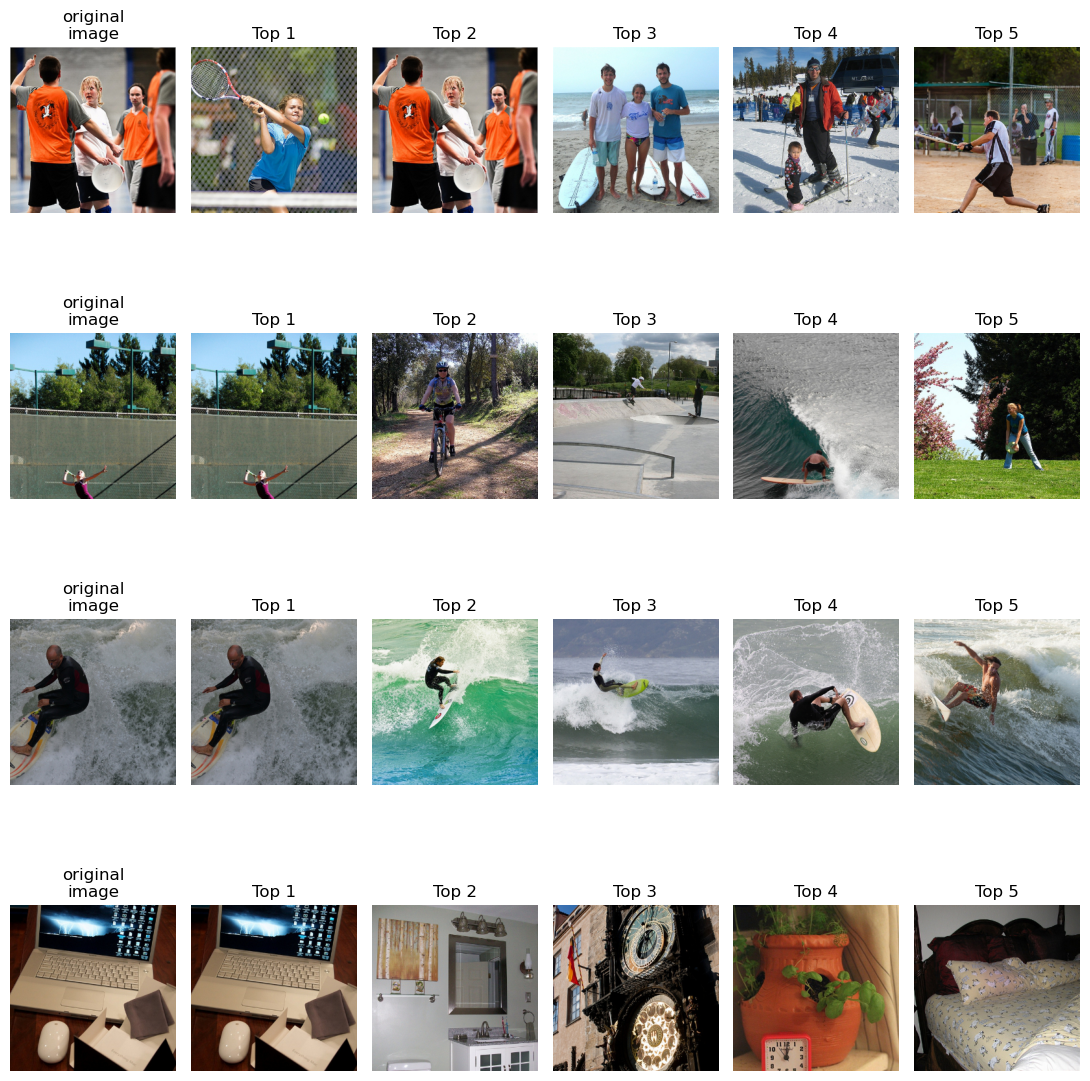

In [12]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

### Zebra example / Retrieval with batch size 982

In [18]:
device = 'cpu' # move to cpu to not OOM with all 982 samples
clip_extractor0 = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
diffusion_prior=diffusion_prior.to(device)

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(982, partial=True)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)
for val_i, (voxel, img_input, coco) in enumerate(tqdm(val_dl,total=1)):
    with torch.no_grad():
        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions

        emb = clip_extractor0.embed_image(img_input.to(device)).float() # CLIP-Image
        
        _, emb_ = diffusion_prior.voxel2clip(voxel.float()) # CLIP-Brain
        
        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)
        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        
        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
        
        cnt=len(fwd_sim)
        percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
        percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            
print(percent_correct_fwd, percent_correct_bwd)
fwd_sim = fwd_sim.numpy()
bwd_sim = bwd_sim.numpy()

ViT-L/14 cpu


  0%|          | 0/1 [01:43<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
zebra_indices = [891, 892, 893, 863, 833, 652, 516, 512, 498, 451, 331, 192, 129, 66]
print("# zebras =", len(zebra_indices))
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(11,5))
for trial,t in enumerate(zebra_indices[:2]):
    ax[trial, 0].imshow(utils.torch_to_Image(img_input[t]))
    ax[trial, 0].set_title("Original image")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[t]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img_input[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

## Brain retrieval visualization

In [ ]:
print("Given Image embedding, find correct Brain embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()